### ➡️ Step: Calculate Log Returns

- 🧠 Why? Because we don’t analyze prices — we analyze returns.
- 📊 What are log returns? A math-friendly way to measure daily % changes.

We want to know how much did the portfolio go up or down each day.  We use log returns because:

- They're symmetric (unlike simple returns)
- The add over time: 2-day return = day1 + day2
- They're more stable for modeling

`r_t = ln(P_t / P_{t-1})`

* P_t = price today
* P_t-1 = price yesterday



In [6]:
import pandas as pd
import numpy as np

# Step 1: Load the saved data
data = pd.read_csv("./data/tsx_adj_close.csv", index_col="Date", parse_dates=True)

print("📅 Data loaded:")
print(f"Shape: {data.shape}")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")

📅 Data loaded:
Shape: (1003, 5)
Date range: 2020-01-02 to 2023-12-29


In [7]:
# Log returns: ln(Pt / Pt-1)
returns = np.log(data / data.shift(1))

# Drop the first row (it will be NaN because there's no Pt-1 for the first day)
returns.dropna(inplace=True)

print(f"📊 Returns shape: {returns.shape}")
print("First 5 rows of returns:")
print(returns.head())

📊 Returns shape: (1002, 5)
First 5 rows of returns:
              BCE.TO    BNS.TO     CP.TO    ENB.TO     RY.TO
Date                                                        
2020-01-03  0.000670 -0.000951 -0.002031 -0.001164 -0.003677
2020-01-06  0.009336 -0.003721  0.003998  0.006966  0.000194
2020-01-07  0.003644 -0.009434  0.009542 -0.004057  0.000388
2020-01-08  0.002642  0.009020 -0.000944  0.007330  0.007912
2020-01-09 -0.005789 -0.001521 -0.004854  0.001536  0.003645


These are daily log returns

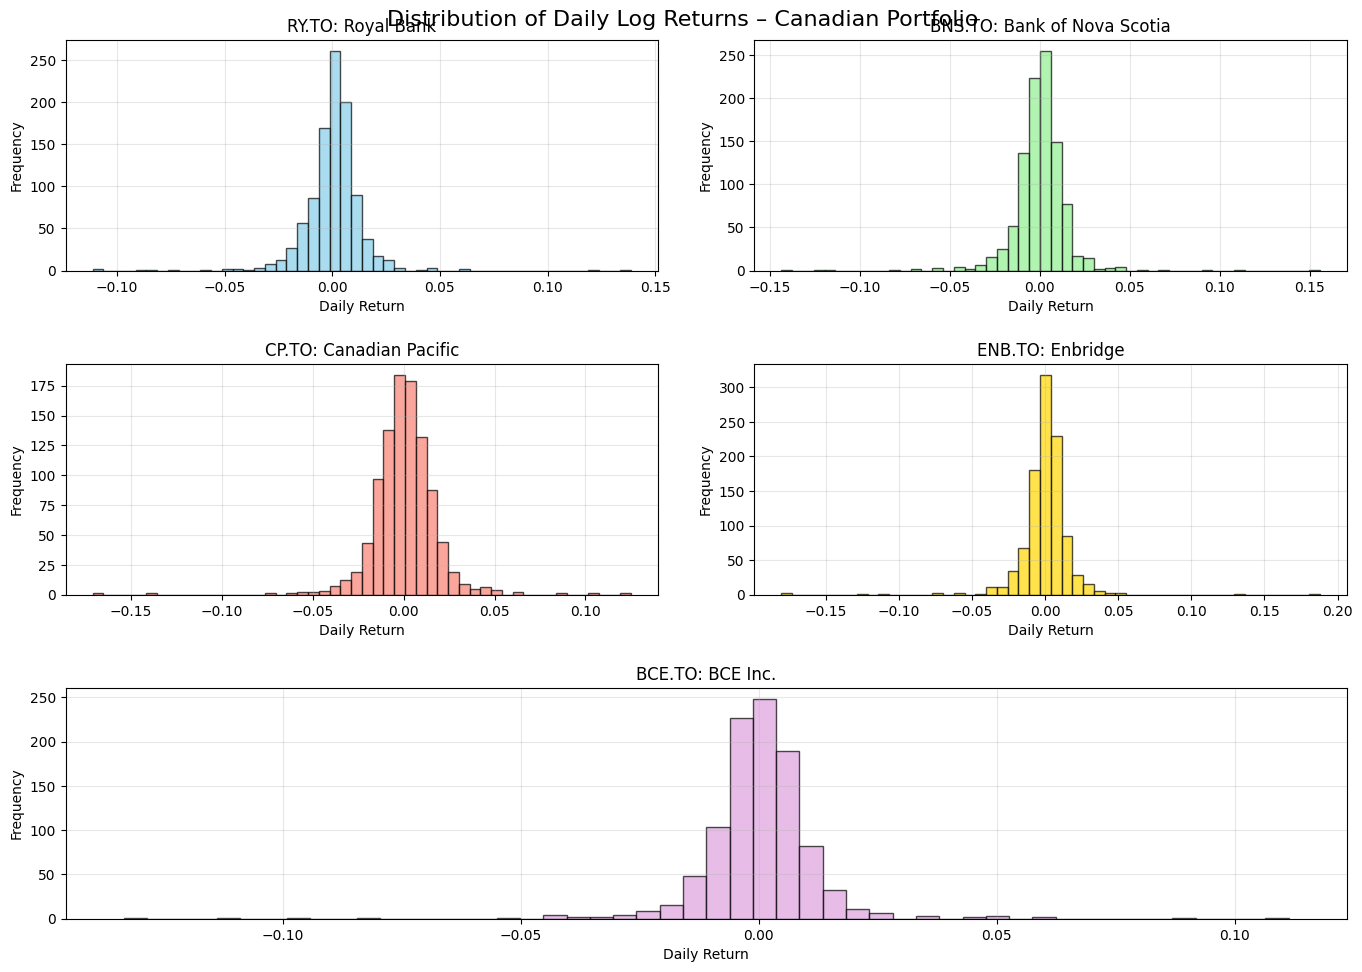

In [8]:
import matplotlib.pyplot as plt

# Get the list of tickers (column names)
tickers = returns.columns.tolist()

# Create a figure with subplots
fig = plt.figure(figsize=(14, 10))

# Plot 1: RY.TO - Top Left
plt.subplot(3, 2, 1)  # 3 rows, 2 cols, position 1
plt.hist(returns['RY.TO'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("RY.TO: Royal Bank")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Plot 2: BNS.TO - Top Right
plt.subplot(3, 2, 2)  # position 2
plt.hist(returns['BNS.TO'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title("BNS.TO: Bank of Nova Scotia")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Plot 3: CP.TO - Middle Left
plt.subplot(3, 2, 3)  # position 3
plt.hist(returns['CP.TO'], bins=50, alpha=0.7, color='salmon', edgecolor='black')
plt.title("CP.TO: Canadian Pacific")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Plot 4: ENB.TO - Middle Right
plt.subplot(3, 2, 4)  # position 4
plt.hist(returns['ENB.TO'], bins=50, alpha=0.7, color='gold', edgecolor='black')
plt.title("ENB.TO: Enbridge")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Plot 5: BCE.TO - Bottom Center (spans both columns)
plt.subplot(3, 2, (5, 6))  # uses positions 5 and 6 → spans full width
plt.hist(returns['BCE.TO'], bins=50, alpha=0.7, color='plum', edgecolor='black')
plt.title("BCE.TO: BCE Inc.")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Adjust layout so plots don't overlap
plt.tight_layout(pad=2.0)
plt.suptitle("Distribution of Daily Log Returns – Canadian Portfolio", 
             fontsize=16, y=0.98)  # Add main title

# Show the full figure
plt.show()

1. All distributions are centered near 0 → no strong trend
2. Most returns are small (±5%) — typical for stocks
3. Tails exist — some days had large moves (especially CP.TO)
4. Symmetry? Most look roughly symmetric, but with fat tails

| Ticker | Behavior                                | Risk Implication                                        |
|--------|-----------------------------------------|---------------------------------------------------------|
| RY.TO  | Narrow peak, low spread → low volatility | Stable bank, less risky                                 |
| BNS.TO | Similar to RY, slightly wider → moderate risk | Also stable, but slightly more volatile             |
| CP.TO  | Wider spread, fatter tails → higher volatility | Transportation sector sensitive to rates, oil      |
| ENB.TO | Very narrow, high peak → very low volatility | Utility-like behavior, defensive stock              |
| BCE.TO | Slight right skew, moderate width → balanced | Telecoms are stable, but not immune to market swings |

### Check Annualized Stats

In [4]:
# Annualized mean return and volatility
annual_return = returns.mean() * 252  # 252 trading days
annual_vol = returns.std() * np.sqrt(252)

# Combine into a summary
summary = pd.DataFrame({
    'Annual Return': annual_return,
    'Annual Volatility': annual_vol,
    'Sharpe Ratio (approx)': annual_return / annual_vol  # No risk-free rate for simplicity
})

print("📈 Annualized Statistics:")
print(summary)

📈 Annualized Statistics:
        Annual Return  Annual Volatility  Sharpe Ratio (approx)
BCE.TO       0.026671           0.206938               0.128882
BNS.TO       0.023017           0.252941               0.090996
CP.TO        0.120899           0.277899               0.435044
ENB.TO       0.049003           0.276309               0.177348
RY.TO        0.105477           0.224272               0.470308


### Next Step: Build an Equal-Weighted Portfolio
Now that we understand individual risks, let’s combine them into a single portfolio return series.

We’ll assume:

* Equal weights: 20% each
* Daily rebalancing
* No transaction costs

In [10]:
# Define equal weights
n_assets = len(returns.columns)
weights = np.array([1/n_assets] * n_assets)  # [0.2, 0.2, 0.2, 0.2, 0.2]

# Calculate portfolio returns
portfolio_returns = returns.dot(weights)

# Add to DataFrame for easy handling
portfolio_returns = pd.DataFrame(portfolio_returns, columns=['Portfolio_Return'])

print("📊 Portfolio Return Stats:")
print(f"Mean return: {portfolio_returns.mean().iloc[0]:.4f}")
print(f"Volatility: {portfolio_returns.std().iloc[0]:.4f}")

📊 Portfolio Return Stats:
Mean return: 0.0003
Volatility: 0.0133


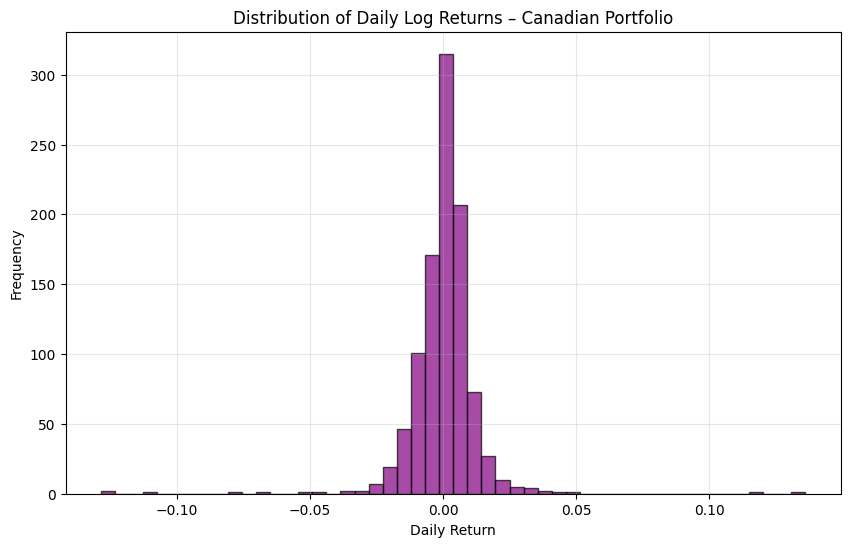

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns['Portfolio_Return'], bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title("Distribution of Daily Log Returns – Canadian Portfolio")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
## Annualize Metrics
annual_return = portfolio_returns.mean() * 252
annual_vol = portfolio_returns.std() * np.sqrt(252)

print(f"Annualized Return: {annual_return.iloc[0]:.2%}")
print(f"Annualized Volatility: {annual_vol.iloc[0]:.2%}")

Annualized Return: 6.50%
Annualized Volatility: 21.06%


| Metric | Value  | Interpretation                             |
|--------|-----------------------------------------|---------------------------------------------------------|
| Annualized Return  | 6.50% | Expected average yearly return (before inflation, fees, taxes)   |
| Annualized Volatility | 21.06% | Standard deviation of returns → measures risk |


- Estimation: earn ~6.5% per year on average
- Actual: with ~21% annual fluctuation — so some years could be +30%, others -15%
- Typical for a moderate-risk equity portfolio

##  Calculate Historical 95% VaR

Now we shift from descriptive stats to risk modeling.  What is the worst daily loss we could expect with 95% confidence?

### Step 1: Calculate Historical 95% VaR (in % return)

In [16]:
# 95% confidence → 5th percentile
var_95 = portfolio_returns.quantile(0.05).iloc[0]

print(f"Historical 95% VaR (daily return): {var_95:.2%}")

Historical 95% VaR (daily return): -1.56%


### Step 2: Convert to Dollar VaR

Assume a $1,000,000 portfolio.

In [17]:
portfolio_value = 1_000_000
var_95_dollars = abs(var_95) * portfolio_value

print(f"95% VaR in dollars: ${var_95_dollars:,.0f}")

95% VaR in dollars: $15,610


With 95% confidence, we won’t lose more than $15.610 in a single day.

### Step 3: Visualize VaR on Return Distribution

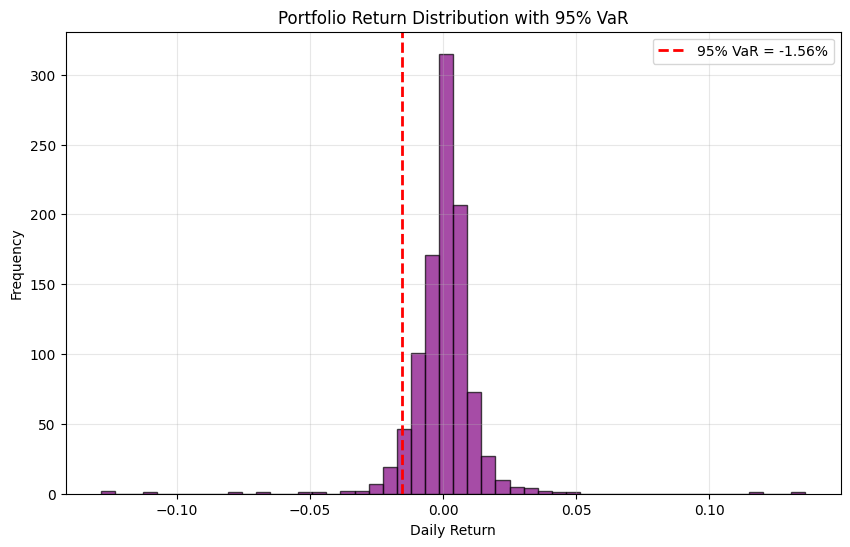

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns['Portfolio_Return'], bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(var_95, color='red', linestyle='--', linewidth=2, label=f'95% VaR = {var_95:.2%}')
plt.title("Portfolio Return Distribution with 95% VaR")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

| Step              | Result                          |
|-------------------|---------------------------------|
| Portfolio Returns | Built from 5 Canadian stocks    |
| Annual Return     | 6.50%                           |
| Annual Volatility | 21.06%                          |
| 95% Daily VaR     | -1.561% or "$15.610"            |

##  Bootstrap VaR confidence interval

How certain are we about this VaR estimate?

### Bootstrap is a non-parametric method that:

1. Resamples data with replacement (same size)
2. Recomputes the statistic (e.g., VaR)
3. Repeats 1,000+ times
4. Builds a distribution of estimates
5. Uses percentiles to get a confidence interval

✅ No assumptions about distribution

✅ Captures uncertainty in your VaR estimate

### Step 1: Set Parameters

In [19]:
np.random.seed(42)  # For reproducibility

n_bootstrap = 1000        # Number of bootstrap samples
confidence_level = 0.95   # For CI around VaR
alpha = 0.05              # 95% VaR → 5th percentile

# Extract portfolio returns as a simple array
returns_array = portfolio_returns['Portfolio_Return'].values

### Step 2: Bootstrap VaR Estimates

In [20]:
bootstrapped_var_95 = []

for i in range(n_bootstrap):
    # Step 1: Resample with replacement
    sample = np.random.choice(returns_array, size=len(returns_array), replace=True)
    
    # Step 2: Compute 95% VaR (5th percentile)
    var_sample = np.percentile(sample, alpha * 100)
    
    # Step 3: Save it
    bootstrapped_var_95.append(var_sample)

# Convert to numpy array
bootstrapped_var_95 = np.array(bootstrapped_var_95)

###  Step 3: Compute 95% Confidence Interval

Now, take the 2.5% and 97.5% percentiles of the bootstrapped VaR values:

In [21]:
ci_lower = np.percentile(bootstrapped_var_95, 2.5)
ci_upper = np.percentile(bootstrapped_var_95, 97.5)

print(f"Bootstrapped 95% Confidence Interval for 95% VaR (return):")
print(f"  [{ci_lower:.2%}, {ci_upper:.2%}]")

Bootstrapped 95% Confidence Interval for 95% VaR (return):
  [-1.72%, -1.41%]


We are 95% confident that the true 95% VaR lies between -1.72% and -1.41%.

### Step 4: Visualize the Bootstrap Distribution

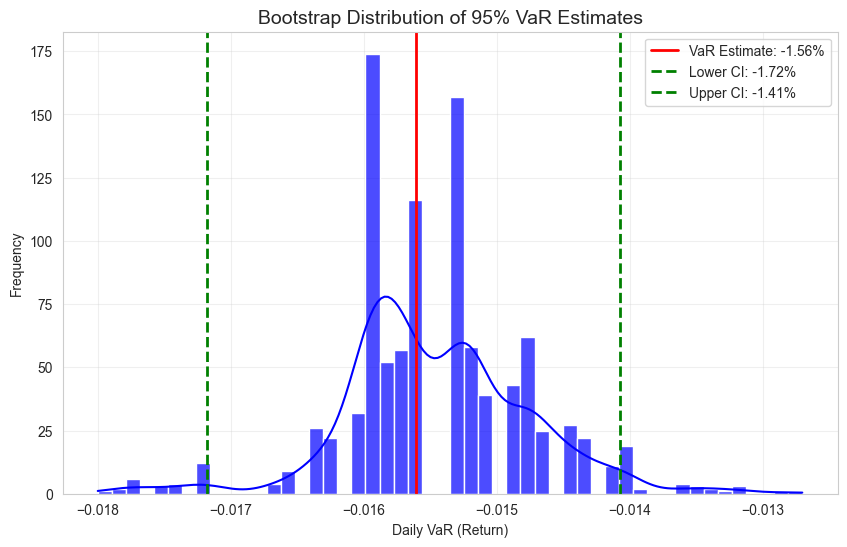

In [22]:
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(bootstrapped_var_95, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(var_95, color='red', linestyle='-', linewidth=2, label=f'VaR Estimate: {var_95:.2%}')
plt.axvline(ci_lower, color='green', linestyle='--', linewidth=2, label=f'Lower CI: {ci_lower:.2%}')
plt.axvline(ci_upper, color='green', linestyle='--', linewidth=2, label=f'Upper CI: {ci_upper:.2%}')
plt.title("Bootstrap Distribution of 95% VaR Estimates", fontsize=14)
plt.xlabel("Daily VaR (Return)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Key Observations:

- Red line (VaR Estimate): −1.56% → your point estimate
- Green dashed lines: 95% CI = [−1.72%, −1.41%]
- Distribution shape: Slightly skewed right, with fat tails
- Peak near −1.6% → most likely VaR value
- Some extreme values → rare but possible large losses

 ✅ This tells us: 

- The true VaR is likely between −1.72% and −1.41%
- The estimate (−1.56%) is within the center of uncertainty
- The model has moderate uncertainty — not too wide, not too narrow